In [1]:
import rasterio as rio
import os
import json
import pandas as pd
from PIL import ImageColor
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, Input, concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from skimage.exposure import rescale_intensity
from rasterio.enums import Resampling
import rasterio.warp as warp

In [2]:
# Location of data
lc_dir = 'data/7Labels.json'
lc_image_dir = r'C:\Users\Usuari\Documents\TFM_Codigos\DATASET\IMAGENES\Rotonda1.tif'
landsat_dir = r'C:\Users\Usuari\Documents\TFM_Codigos\DATASET\MASCARAS\010.tif'

#lc_image_dir = r'C:\Users\Usuari\Documents\TFM_Codigos\SateliteDANA\d025.tif'


4
Normalized bands
0.0 - 1.0 mean: 0.5262714974282469
0.0 - 1.0 mean: 0.4417487319765426
0.0 - 1.0 mean: 0.3783388567424191


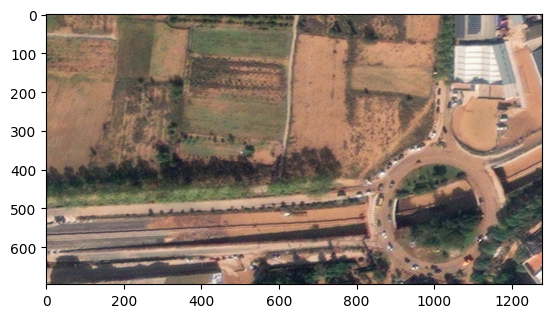

In [3]:
# Load satellite imagery
landsat = rio.open(lc_image_dir)
landsat_image = landsat.read() /1000
landsat.read()
print(landsat.count)
red = landsat.read(1)
green = landsat.read(2)
blue = landsat.read(3)

def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

In [4]:
def pad_image(image, patch_size):
    """Pad the image to make its dimensions divisible by patch_size."""
    h, w, _ = image.shape
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
    return padded_image, (h, w)

def split_image_into_patches(image, patch_size):
    """Divide una imagen en parches de tamaño `patch_size x patch_size`."""
    patches = []
    h, w, _ = image.shape
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
    return np.array(patches)

def combine_patches_into_image(patches, original_shape, patch_size):
    """Combina los parches de vuelta a la imagen original."""
    h, w = original_shape
    padded_h = (h + patch_size - 1) // patch_size * patch_size
    padded_w = (w + patch_size - 1) // patch_size * patch_size
    output_image = np.zeros((padded_h, padded_w))
    patch_index = 0
    for i in range(0, padded_h, patch_size):
        for j in range(0, padded_w, patch_size):
            output_image[i:i+patch_size, j:j+patch_size] = patches[patch_index]
            patch_index += 1
    return output_image[:h, :w]

# Cargar la imagen compuesta (composite)
# Asegúrate de que `composite` tenga la forma original (2560, 2560, 3)
# Aquí deberías cargar o generar tu arreglo `composite`

# Dividir la imagen en parches de tamaño 128x128
patch_size = 128
padded_rgb, original_shape = pad_image(rgb, patch_size)
patches = split_image_into_patches(padded_rgb, patch_size)

# Cargar el modelo
model = keras.saving.load_model(r'C:\Users\Usuari\Documents\TFM_Codigos\MODELO\kerasmodels\UNET40_7L_Javi.keras')

# Predecir cada parche
predicted_patches = []
for patch in patches:
    # Expandir dimensiones para cada parche
    input_patch = np.expand_dims(patch, axis=0)
    prediction = model.predict(input_patch)
    predicted_patch = np.argmax(prediction, axis=3)[0]
    predicted_patches.append(predicted_patch)

# Combinar los parches de vuelta a la imagen completa
predicted_image = combine_patches_into_image(np.array(predicted_patches), original_shape, patch_size)

print("Predicción completada.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/

In [7]:
# Prepare input
padded_rgb, original_shape = pad_image(rgb, patch_size)
patches = split_image_into_patches(padded_rgb, patch_size)

# Apply model
model = keras.saving.load_model(r'C:\Users\Usuari\Documents\TFM_Codigos\MODELO\kerasmodels\UNET40_7L_Javi.keras')

# Predict each patch
predicted_patches = []
for patch in patches:
	input_patch = np.expand_dims(patch, axis=0)
	prediction = model.predict(input_patch)
	predicted_patch = np.argmax(prediction, axis=3)[0]
	predicted_patches.append(predicted_patch)

# Combine patches back into the original image
prediction_image = combine_patches_into_image(np.array(predicted_patches), original_shape, patch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/

In [8]:
#lc_dir= r'C:\Users\Usuari\Documents\TFM_Codigos\DATASET\ESA\7Labels.json' #Si usamos el modelo de ESA
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index #+ 1
lc_df["palette"] = "#" + lc_df["palette"]
# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Creación del mapa de colores para la visualización
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}
lc_df

,palette,values,label,values_normalize
0,#009150,0,Arboles,0
1,#90EE90,1,Sotobosque,1
2,#FFFF00,2,Tierra,2
3,#666666,3,Infraestructura,3
4,#000000,4,Sombra,4
5,#0000FF,5,Agua,5
6,#FF0033,6,No Clasificado,6


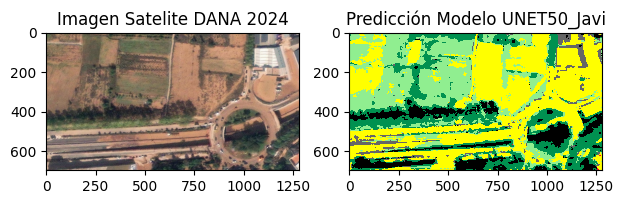

In [11]:
plt.figure(figsize=(15, 5))
# Show composite
plt.subplot(1, 4, 1)
plt.title('Imagen Satelite DANA 2024')
plt.imshow(rgb)
"""
# Load land cover image
lc_source = rio.open(lc_image_dir)
lc_image = rio.open(landsat_dir).read(1)
plt.subplot(1, 4, 2)
plt.title('Ground Truth/Máscara')
plt.imshow(lc_image, cmap=cmap, vmin=0, vmax=6, interpolation='nearest')
"""
# Showed it compared to other image
plt.subplot(1, 4, 2)
plt.title('Predicción Modelo UNET50_Javi')
plt.imshow(prediction_image, cmap=cmap, vmin=0, vmax=6, interpolation='nearest')


In [ ]:
#"""
height, width = prediction_image.shape
output = rio.open(
	'DL3_GS2.tif',
	'w',
	driver='COG',
	width= width,
	height= height,
	count=1,
	crs=lc_source.crs,
	transform=lc_source.transform,
	nodata=0,
	dtype='uint8',
	compress='lzw',
	resampling=Resampling.nearest
)
output.write(prediction_image, 1)
output.write_colormap(1, dict_palette)
output.close()
#"""


"\nheight, width = prediction_image.shape\noutput = rio.open(\n\t'DL3_GS2.tif',\n\t'w',\n\tdriver='COG',\n\twidth= width,\n\theight= height,\n\tcount=1,\n\tcrs=lc_source.crs,\n\ttransform=lc_source.transform,\n\tnodata=0,\n\tdtype='uint8',\n\tcompress='lzw',\n\tresampling=Resampling.nearest\n)\noutput.write(prediction_image, 1)\noutput.write_colormap(1, dict_palette)\noutput.close()\n"